# **<center>Prédiction des chefs de famille**

Dans ce notebook, nous allons travailler sur une base de données de recensement. Après étude de ces données, nous chercherons à prédire si un individu au sein d'un foyer est un chef de famille.

# **Imports**

In [ ]:
# pip install transformers[torch]

In [ ]:
import pandas as pd
import numpy as np
import json
import yaml
import torch
import re
import transformers

import matplotlib.pyplot as plt
import plotly.express as px

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from gensim.models import FastText

from wordcloud import WordCloud

pd.set_option('display.max_colwidth', None)

# **Lecture des données**

**Import du fichier JSON contenant les données**

In [ ]:
# Lecture du fichier JSON
with open('data/entities.json', 'r', encoding='utf-8') as fichier:
    donnees = json.load(fichier)

Cartaines lignes font mention du mot "idem" qui correspond à la catégorie de la personne précédente. On traite donc les informations "idem" de la liste en prenant les caractéristiques de la personne précédente.

In [ ]:
pattern = r'.(?=idem)'

for num_page, text_page in donnees.items():
    liste_personne = text_page.split("\n")

    for i, personne in enumerate(liste_personne):
        match = re.search(pattern, personne)

        if match:
            # Extraire le token trouvé
            token = match.group(0)
            # Récupérer l'élément précédent dans la liste
            element_precedent = liste_personne[i - 1]
            # Appliquer une expression régulière sur l'élément précédent pour extraire l'information associée au token
            info_associated_match = re.search(re.escape(token) + r'\s*(\S+)', element_precedent)
            if info_associated_match:
                # Extraire l'information associée
                info_associated = info_associated_match.group(1)
                liste_personne[i] = liste_personne[i].replace("idem", info_associated)
    # Remplacer dans le dictionnaire
    donnees[num_page] = "\n".join(liste_personne)



**Import des tokens**

In [ ]:
with open('data/tokens.yml', 'r', encoding='utf-8') as yaml_file:
    tokens = yaml.safe_load(yaml_file)


On remplace les tokens qui étaient dans la liste caractéristiques des individus puis on récupère toutes les cractéristiques des individus :

In [ ]:
def remplacer_tokens(donnees_dict, tokens_dict):
    for cle, valeur in donnees_dict.items():
        for champ, token in tokens_dict.items():
            valeur = valeur.replace(token['start'], f"{champ} ")
            valeur = valeur.replace(token['end'], '')
        donnees[cle] = valeur
    return donnees

In [ ]:
donnees_without_token = remplacer_tokens(donnees, tokens)
donnees_without_token = list(donnees_without_token.values())

liste_donnees_withouts_token = [sous_liste for sous_liste in donnees_without_token]

liste_data = [text.split("\n") for text in liste_donnees_withouts_token]
liste_data = [sous_element for liste in liste_donnees_withouts_token for sous_element in liste.split("\n")]


Ensuite on transforme nos listes en un dataframe. Pour cela, nous commençons d'abord par créer un dictionnaire en extrayant les noms de chaque caractéristique des individus pour les mettre en clés :

In [ ]:
col_to_create = list(tokens.keys())

def extraire_col_name(texte):
    donnees_dict = {}
    for champ in col_to_create:
        valeur = re.search(rf'\b{champ}\b (\S+)', texte)
        if valeur:
            donnees_dict[champ] = valeur.group(1)
        else:
            donnees_dict[champ] = None
    return donnees_dict

# Créer une liste de dictionnaires à partir des données
donnees_liste = [extraire_col_name(texte) for texte in liste_data]


### DF des données :

In [ ]:
df_data = pd.DataFrame(donnees_liste)

On corrige les occurences de "néant" en None :


In [ ]:
df_data.replace(["Neant", "néant", "neant"], None, inplace=True)

On supprime les colonnes vides :

In [ ]:
df_data.dropna(axis=1, how='all', inplace=True)

In [ ]:
df_data

,age,birth_date,civil_status,education_level,employer,firstname,link,lob,maiden_name,nationality,observation,occupation,surname,surname_household
0,25,None,Garçon,None,None,Cyrille,None,None,None,française,None,menuisier,Breton,None
1,30,None,Garçon,None,None,Auguste,None,None,None,Piémontaise,None,vitrier,None,Ferazzi
2,24,None,Garçon,None,None,Pierre,None,None,None,Piémontaise,None,vitrier,None,Machol
3,48,None,Homme,None,None,Alexandre,None,None,None,française,None,prop,None,Desbois
4,30,None,None,None,None,Zélie,sa,None,None,française,None,prop,Vignat,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25443,None,1887,None,None,None,Annunziata,épouse,italienne,None,italienne,None,None,Berni-Laureti,None
25444,None,1914,None,None,None,Primo,fils,italienne,None,italienne,None,None,Berni,None
25445,None,None,None,None,None,None,None,None,None,None,None,None,None,None
25446,None,None,None,None,None,None,None,None,None,None,None,None,None,None


On ne regarde que les lignes où la colonnes "link" n'est pas vide pour travailler seulement sur les individus pour lequel il est présent :

In [ ]:
df_data.dropna(subset=['link'], inplace=True)

Le df comporte 20581 lignes contenant le lien de l'individu dans la famille.

In [ ]:
df_data

,age,birth_date,civil_status,education_level,employer,firstname,link,lob,maiden_name,nationality,observation,occupation,surname,surname_household
4,30,None,None,None,None,Zélie,sa,None,None,française,None,prop,Vignat,None
10,30,None,Femme,None,None,Mathilde,sa,None,None,française,None,profess,de,None
11,11,None,Garçon,None,None,Georges,le,None,None,française,None,None,de,None
12,8,None,Garçon,None,None,Henro,le,None,None,française,None,None,de,None
13,5,None,Garçon,None,None,Gaston,le,None,None,française,None,None,de,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25440,None,1869,None,None,None,Marie,chef,Pailharès,None,idem,None,None,None,Chameton-Dideron
25441,None,1863,None,None,Cara,Marie,chef,St,None,idem,None,ouv,None,Ode
25442,None,1886,None,None,Baretto,Nello,chef,Castel,None,italienne,None,manoeuvre,None,Berni
25443,None,1887,None,None,None,Annunziata,épouse,italienne,None,italienne,None,None,Berni-Laureti,None


In [ ]:
df_data.describe()

,age,birth_date,civil_status,employer,firstname,link,lob,nationality,observation,occupation,surname,surname_household
count,12985,7028,6744,2758,20514,20581,8373,12360,397,11574,16261,4107
unique,126,149,6,928,1270,483,2212,296,138,985,6702,3012
top,2,1901,Fille,patron,Marie,chef,St,française,veuve,cultivateur,idem,Le
freq,329,136,1934,660,2912,4485,553,7685,61,1275,204,33


De plus, il y a 4590 lignes où la personne est "chef". Donc il y a à peu près un quart des individus dans les données qui sont des chefs, ce qui est bien pour la prédiction.

In [ ]:
df_data.loc[df_data["link"].isin(["CHEF", "chef", "Chef", "chf", "cheg", ]), "is_chef"] = 1
df_data["is_chef"].fillna(0, inplace=True)

df_chef = df_data[df_data["link"].isin(["CHEF", "chef", "Chef", "chf", "cheg", ])]

In [ ]:
df_chef


,age,birth_date,civil_status,employer,firstname,link,lob,nationality,observation,occupation,surname,surname_household,is_chef
37,None,1877,None,P.O,Elie,chef,Cercottes,française,None,tourneur,None,Furet,1.0
42,None,1879,None,None,Gaston,chef,Landes,française,None,cocher,None,Poitout,1.0
43,None,1883,None,Cartier,Jean,chef,Teillet,française,None,scieur,None,Chometon,1.0
46,None,1872,None,Charpentier,Louis,chef,Ruan,française,None,journalier,None,Debard,1.0
52,None,1860,None,None,Germaine,chef,None,française,None,domestique,None,Hatton,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
25435,None,1855,None,None,Augusta,chef,Bésayes,idem,None,None,None,Turpin-Faucon,1.0
25437,None,1856,None,None,Raymond,chef,idem,idem,None,None,None,Lambert,1.0
25440,None,1869,None,None,Marie,chef,Pailharès,idem,None,None,None,Chameton-Dideron,1.0
25441,None,1863,None,Cara,Marie,chef,St,idem,None,ouv,None,Ode,1.0


## Statistiques descriptives sur les chefs de famille :

Dans cette partie, nous n'effectuons des statistiques descriptives que sur les chefs de famille.

**Sur les civil_status :**

In [ ]:
fig = px.histogram(df_chef, x='civil_status', title='Histogramme de fréquence des status des chefs', histnorm='percent', labels={'civil_status': 'Status civil', 'percent': 'Pourcentage d\'apparition'})
fig.show()

Près de 79% des chefs sont des hommes + 8% sont des veufs donc au total il y a 87% d'hommes. Il y a très peu de femmes (10%) et lorsqu'elles sont cheffes, c'est parcequ'elles sont veuves (8%).

**Sur les âges :**

Il y a des anomalies, parfois les années ont été mises à la place de l'âge

In [ ]:
df_chef["age"] = pd.to_numeric(df_chef["age"], errors='coerce')
fig = px.histogram(df_chef.loc[df_chef["age"]<=100], x='age', title='Histogramme de fréquence des âges des chefs', histnorm='percent')
fig.show()

<ipython-input-19-7050a6e5500c>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



L'histogramme représente une gaussienne, avec la majorité des chefs qui ont entre 30 et 70 ans.

In [ ]:
df_chef.loc[df_chef["age"]<=100].describe()

,age,is_chef
count,2562.000000,2562.0
mean,49.563232,1.0
std,14.744581,0.0
min,16.000000,1.0
25%,38.000000,1.0
50%,49.000000,1.0
75%,61.000000,1.0
max,98.000000,1.0


**Sur les firstname :**

In [ ]:
df_chef.groupby("firstname").size().reset_index(name='count').sort_values(by='count', ascending=False).head(10)

,firstname,count
297,Jean,497
440,Pierre,294
373,Marie,222
340,Louis,222
224,François,172
310,Joseph,140
63,Antoine,114
261,Henri,90
84,Auguste,89
117,Charles,75


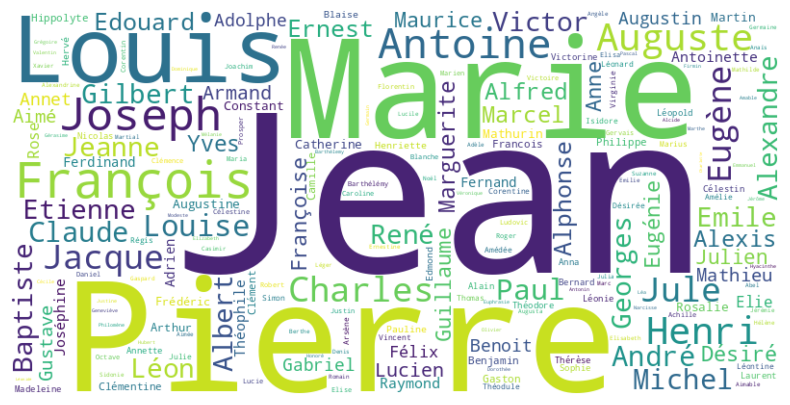

In [ ]:
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(df_chef["firstname"].str.cat(sep=' '))

# Afficher le nuage de mots
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


On voit que la plupart des prénoms sont masculins.

**Sur les occupations :**

In [ ]:
df_chef.groupby("occupation").size().reset_index(name='count').sort_values(by='count', ascending=False).head(10)

,occupation,count
306,cultivateur,574
298,cult,243
423,journalier,222
553,prop,92
601,sans,88
563,propriétaire,85
369,fermier,81
424,journalière,63
350,employé,60
593,s.p,57


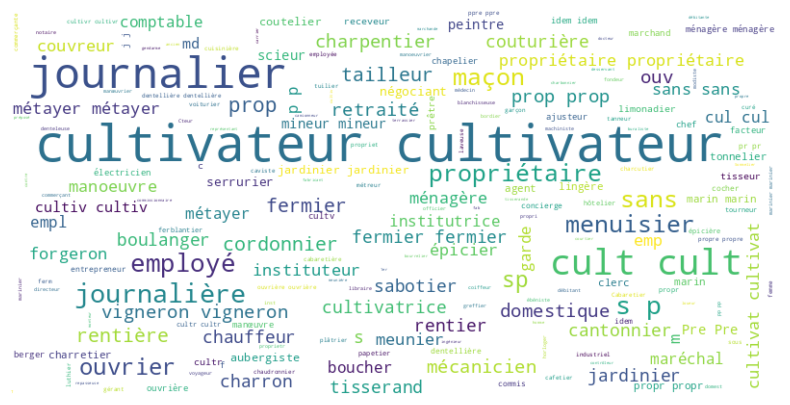

In [ ]:
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(df_chef["occupation"].str.cat(sep=' '))

# Afficher le nuage de mots
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


Sur les observations :

In [ ]:
df_chef.groupby("observation").size().reset_index(name='count').sort_values(by='count', ascending=False).head(10)

,observation,count
41,veuve,32
35,marié,17
33,m,6
21,Veuve,5
40,veuf,4
36,occupé,2
0,+,2
3,34,1
4,36,1
1,27,1


# Modélisation

Dans cette partie, nous allons tenter de prédire au mieux si un individu est chef de famille. Pour cela, nous allons implémenter plusieurs modèles et nous allons analyser leurs performances.

On process les données pour la modélisation. On crée une phrase à partir des autres colonnes du df. Cette phrase permet de caractériser les individus, et c'est celle-ci que l'on va passer en input de notre modèle.

In [ ]:
df_data['age'].fillna('', inplace=True)
df_data['civil_status'].fillna('', inplace=True)
df_data['occupation'].fillna('', inplace=True)
df_data['firstname'].fillna('', inplace=True)
df_data['lob'].fillna('', inplace=True)
df_data['nationality'].fillna('', inplace=True)
df_data['surname'].fillna('', inplace=True)
df_data['surname_household'].fillna('', inplace=True)

# On ajoute des séparateurs propres aux noms des colonnes pour les séparer
df_data["caracteristique"] = " <A> " + df_data["age"].astype(str) + " ans " + " <CS> "+ df_data["civil_status"] + " <O> " + df_data["occupation"] + " <F> " + df_data["firstname"] + " <L> " + df_data["lob"] + " <N> " + df_data["nationality"] + " <S> " + df_data["surname"] + " <SH> " + df_data["surname_household"]

X = df_data["caracteristique"].tolist()
y = df_data["is_chef"].tolist()

Ensuite, on découpe notre jeu de données en trois dataset (training, evaluation et test).

In [ ]:
train_texts, test_texts, train_labels, test_labels = train_test_split(X, y, test_size=.2)
# eval data :
train_texts, val_texts, train_labels, val_labels = train_test_split(train_texts, train_labels, test_size=0.2, random_state=42)


## **Modélisation avec CamembertForSequenceClassification :**

On convertit nos labels avec du one hot encoding pour pouvoir les passer plus tard dans notre modèle :

In [ ]:
# Convert the integer labels to one-hot encoded format
encoder = OneHotEncoder(sparse=False)
train_labels_encoded = encoder.fit_transform(np.array(train_labels).reshape(-1, 1))
test_labels_encoded = encoder.transform(np.array(test_labels).reshape(-1, 1))
val_labels_encoded = encoder.transform(np.array(val_labels).reshape(-1, 1))

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning:

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.



Puis nous importons le tokenizer ainsi que le model :

In [ ]:
tokenizer = transformers.CamembertTokenizer.from_pretrained("camembert-base")

model = transformers.CamembertForSequenceClassification.from_pretrained("camembert-base", num_labels=2)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at camembert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Nous tokenizons les données :

In [ ]:
train_encodings = tokenizer(train_texts, truncation=True, padding=True)
test_encodings = tokenizer(test_texts, truncation=True, padding=True)
val_encodings = tokenizer(val_texts, truncation=True, padding=True)

Nous modifions le format des données afin qu'elles soient utilisable par les modèles de la librairie `torch` :

In [ ]:
class RecensementDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = RecensementDataset(train_encodings, train_labels_encoded)
test_dataset = RecensementDataset(test_encodings, test_labels_encoded)
val_dataset = RecensementDataset(val_encodings, val_labels_encoded)

Nous commençons l'entrainement du modèle :

**NOTE :** la loss tend à se stabiliser rapidement, nous mettons donc un faible nombre de training epochs


In [ ]:
# Define the training arguments
training_args = transformers.TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=3,              # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=64,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=100,
)


# Define the Trainer
trainer = transformers.Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=val_dataset            # evaluation dataset
)

# Start training
trainer.train()


Step,Training Loss
100,0.176000
200,0.177800
300,0.186400
400,0.218800
500,0.209300
600,0.222500
700,0.229000
800,0.236000
900,0.227200
1000,0.213300


TrainOutput(global_step=2472, training_loss=0.2153055737319502, metrics={'train_runtime': 440.1472, 'train_samples_per_second': 89.772, 'train_steps_per_second': 5.616, 'total_flos': 934043218750440.0, 'train_loss': 0.2153055737319502, 'epoch': 3.0})

Après avoir entrainer notre modèle, nous testons ses performances de prédictions sur l'ensemble de test :

In [ ]:
# Faire des prédictions sur l'ensemble de test
predictions = trainer.predict(test_dataset)

# Obtenir les prédictions de classe (0 ou 1)
predicted_labels = np.argmax(predictions.predictions, axis=1)

# Calculer le F1-score
f1 = f1_score(test_labels, predicted_labels)
accuracy = accuracy_score(test_labels, predicted_labels)
auc_roc = roc_auc_score(test_labels, predicted_labels)
conf_matrix = confusion_matrix(test_labels, predicted_labels)

# Afficher les metriques
print("F1-score:", f1)
print("Accuracy:", accuracy)
print("AUC-ROC:", auc_roc)
print("Confusion matrix:", conf_matrix)

Predictions: [0 0 0 ... 0 0 1]
F1-score: 0.8835855646100117
Accuracy: 0.9514209375759047
AUC-ROC: 0.9121812552111804
Confusion matrix: [[3158   58]
 [ 142  759]]


*DF des résultats :*

Nous allons regarder quels sont les caractéristiques des individus qui sont mal prédits :

In [ ]:
df_results_test = pd.DataFrame({'text': test_texts, 'true_label': test_labels, 'predicted_label': predicted_labels})


In [ ]:
df_results_test.loc[(df_results_test["true_label"]==1)&(df_results_test["predicted_label"]==0)].head(140)

,text,true_label,predicted_label
35,<A> 54 ans <CS> Homme <O> cultivateur <F> Pierre <L> <N> <S> Roy <SH>,1.0,0
72,<A> ans <CS> <O> journalier <F> Pierre <L> Reims <N> journalier <S> <SH>,1.0,0
82,<A> 59 ans <CS> <O> ménagère <F> Françoise <L> <N> cult <S> Le <SH>,1.0,0
101,<A> 62 ans <CS> Homme <O> roulier <F> Auguste <L> <N> française <S> Quillery <SH>,1.0,0
109,<A> ans <CS> <O> officier <F> Jacques <L> Chaumont <N> française <S> de <SH>,1.0,0
...,...,...,...
4012,<A> ans <CS> <O> <F> Jean <L> Riec <N> Gourlet <S> Guelt <SH>,1.0,0
4050,<A> 27 ans <CS> <O> journalier <F> Laurent <L> <N> <S> Godignon <SH>,1.0,0
4063,<A> 24 ans <CS> <O> Sommelier <F> Pierre <L> <N> <S> Herten <SH>,1.0,0
4079,<A> 55 ans <CS> <O> prop <F> Pierre <L> <N> <S> Gillouin <SH>,1.0,0


Dès qu'il n'y a pas le civil_status, le modèle a beaucoup de mal à bien prédire les chefs.

## **Modélisation avec TF-IDF :**

Nous voulons tester les performances de notre modèle de transformers avec d'autres modèles plus simples. Pour cela, nous commençons par comparer avec un encoding TF-IDF et un classifieur random forest.

In [ ]:
vectorizer = TfidfVectorizer(max_features=10000)
X_train = vectorizer.fit_transform(train_texts)
X_test = vectorizer.transform(test_texts)

# Entraînement du modèle
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, train_labels)

# Évaluation du modèle

predicted_labels = clf.predict(X_test)

f1 = f1_score(test_labels, predicted_labels)
accuracy = accuracy_score(test_labels, predicted_labels)
auc_roc = roc_auc_score(test_labels, predicted_labels)
conf_matrix = confusion_matrix(test_labels, predicted_labels)

print("F1-score:", f1)
print("Accuracy:", accuracy)
print("AUC-ROC:", auc_roc)
print("Confusion matrix:", conf_matrix)


F1-score: 0.3983539094650206
Accuracy: 0.8224435268399319
AUC-ROC: 0.623101197674226
Confusion matrix: [[3144   72]
 [ 659  242]]


## **Modélisation avec FastText :**

Nous testons cette fois-ci avec l'encoding FastText :

In [ ]:
fasttext_model = FastText(sentences=train_texts, vector_size=100, window=5, min_count=5, workers=4, sg=1)

# Obtenir les embeddings de texte pour chaque exemple
train_embeddings = np.array([fasttext_model.wv[words.split()].mean(axis=0) for words in train_texts])
test_embeddings = np.array([fasttext_model.wv[words.split()].mean(axis=0) for words in test_texts])

# Entraîner un modèle sur les embeddings de texte
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(train_embeddings, train_labels)

# Évaluation du modèle

predicted_labels = rf_model.predict(test_embeddings)

f1 = f1_score(test_labels, predicted_labels)
accuracy = accuracy_score(test_labels, predicted_labels)
auc_roc = roc_auc_score(test_labels, predicted_labels)
conf_matrix = confusion_matrix(test_labels, predicted_labels)

print("F1-score:", f1)
print("Accuracy:", accuracy)
print("AUC-ROC:", auc_roc)
print("Confusion matrix:", conf_matrix)

F1-score: 0.457271364317841
Accuracy: 0.8241437940247753
AUC-ROC: 0.6493558842855643
Confusion matrix: [[3088  128]
 [ 596  305]]


## **Modélisation avec les encodings de CamembertModel :**

Nous testons avec la dernière couche d'encodings du modèle Cammembert :

In [ ]:
model = transformers.CamembertModel.from_pretrained('camembert-base')

NameError: name 'transformers' is not defined

In [ ]:
train_encodings = tokenizer(train_texts, truncation=True, padding=True, return_tensors='pt')

with torch.no_grad():
    outputs = model(**train_encodings)
    pooled_output = outputs.pooler_output

train_features, test_features, y_train, y_test = train_test_split(pooled_output.numpy(), train_labels)

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(train_features, y_train)

# Evaluation du modèle

predicted_labels = rf_model.predict(test_features)

f1 = f1_score(y_test, predicted_labels)
accuracy = accuracy_score(y_test, predicted_labels)
auc_roc = roc_auc_score(y_test, predicted_labels)
conf_matrix = confusion_matrix(y_test, predicted_labels)

print("F1-score:", f1)
print("Accuracy:", accuracy)
print("AUC-ROC:", auc_roc)
print("Confusion matrix:", conf_matrix)
